In [1]:
import random
import pandas as pd
import seaborn as sns  # Assuming seaborn is installed
import matplotlib.pyplot as plt 

In [2]:
noise = False 
prompt = True
sample_size = 3000 
batch_size = 32 

In [3]:
import numpy as np 
import re 
data_csv = f'./../../../toy-data/exp2/data_1.csv'

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=32, replace=False)
df = df.loc[indices].reset_index(drop=True)
df['label'] = [random.randint(0, 1) for _ in range(df.shape[0])]
df.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Description,label
0,10,0,0,798,2,35,1,1,0,The tenant is a 57-year-old individual who has...,0
1,4,1,2,1276,0,23,0,0,0,The tenant is a 37-year-old individual with mo...,0
2,6,2,4,1229,5,52,1,1,0,The tenant is a 45-year-old individual who is ...,1
3,8,0,1,842,0,20,1,1,0,The tenant is a 52-year-old individual with mo...,1
4,7,1,4,977,0,17,1,1,1,The tenant is a 47-year-old individual with mo...,1


In [4]:
conditions_not_covered = [
    "Short-term illnesses",
    "Temporary exhaustion",
    "Behavioral Traits and Conditions",
    "Having a quick temper without any underlying medical condition",
    "Certain Addictions",
    "Substance abuse disorders",
    "good health"
]

conditions_covered = [
    "Mobility impairments",
    "Visual impairments",
    "Hearing impairments",
    "Chronic illnesses",
    "Respiratory disorders",
    "Cardiovascular conditions",
    "Intellectual disabilities",
    "Learning disabilities",
    "Autism spectrum disorders",
    "Psychiatric disorders",
    "Traumatic brain injuries",
    "Alzheimer's disease and other dementias"
]

disabilities = conditions_covered + conditions_not_covered

# Create a list of (0,1)s
severity_indicator = [1 if disability in conditions_covered else 0 for disability in disabilities]

def fstage(var1, var2, var3, var4, var5, var6, var7, var8, var9):
    return 0.35*severity_indicator[var5] + 0.35*var9

In [5]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n'
string1 = "Note: Some tenants have access to a free lawyer others don't. This tenant **has access** to a free lawyer.\n\n"
string0 = "Note: Some tenants have access to a free lawyer others don't. This tenant **does not have access** to a free lawyer.\n\n"
if prompt:

    context = "Also Note: Access to a lawyer does not mean the tenant will be represented in court by a lawyer." \
        " If the tenant is given access to a lawyer, they must apply for representation." \
        " Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications." \
        " Providers can differ over what they consider to be a dissability."\
        " If a tenant's application is selected, they must follow-up with the provider to arange for legal representation." \
        " Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation."
else:
    context = ''

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4'], 
                                                 row['Var5'],
                                                 row['Var6'],
                                                 row['Var7'],
                                                 row['Var8'],
                                                 row['Var9']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             string_b + string1 + 'Description:' + df['Description'].replace("\n", "") + '\n\n' + context,
                             string_b + string0 + 'Description:' + df['Description'].replace("\n", "") + '\n\n'+ context)

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + string1 + 'Description:' + row['Description'].replace("\n", "") + '\n\n' + context, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + string0 + 'Description:' + row['Description'].replace("\n", "") + '\n\n' + context, axis=1)

# Sample Treatment Values
df['label'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['label'] + 0.1*np.random.normal(size=sample_size)

In [6]:
var = "FullDescription"
data = df

In [7]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader


model_id = "microsoft/phi-3-mini-4k-instruct" #"microsoft/phi-3-mini-4k-instruct" # "meta-llama/Meta-Llama-3-8B-Instruct" #"meta-llama/Meta-Llama-3-8B" # #
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

def tokenizer_function(example):
  return tokenizer.apply_chat_template(example["messages"], 
                                       truncation=True, 
                                       max_length=512, 
                                       tokenize=True, 
                                       add_generation_prompt=False, 
                                       return_dict=True)

dataset = []
for index, row in df.iterrows():
  entry = [
      {'role': 'user', 'content': f"Task: {row['FullDescription']}"},
      {'role': 'assistant', 'content': 'No' if row['label'] == 0 else 'Yes'}
  ]
    
  dataset.append(entry)


dataset = Dataset.from_dict({'messages': dataset, 'labels': df['label'].values})
tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['messages'])

data_loader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [8]:
import torch
from transformers import Phi3ForSequenceClassification, AdamW
model_id = "microsoft/phi-3-mini-4k-instruct"

# Load the model
model = Phi3ForSequenceClassification.from_pretrained(model_id,
                                                           device_map='auto',
                                                           num_labels=2, 
                                                           torch_dtype=torch.bfloat16,
                                                           attn_implementation="flash_attention_2")

model.gradient_checkpointing_enable()
model.config.use_cache = False # Doesn't work with gradient checkpointing.

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Phi3ForSequenceClassification were not initialized from the model checkpoint at microsoft/phi-3-mini-4k-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


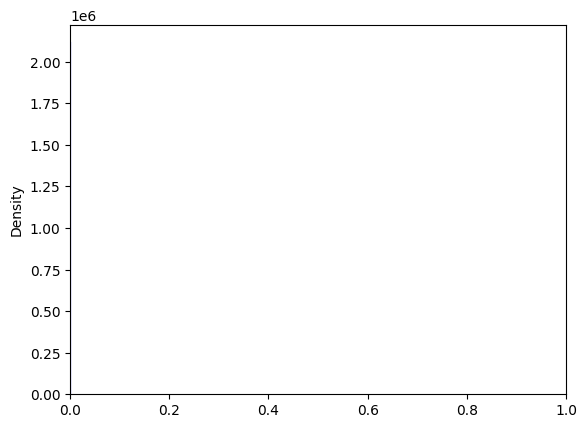

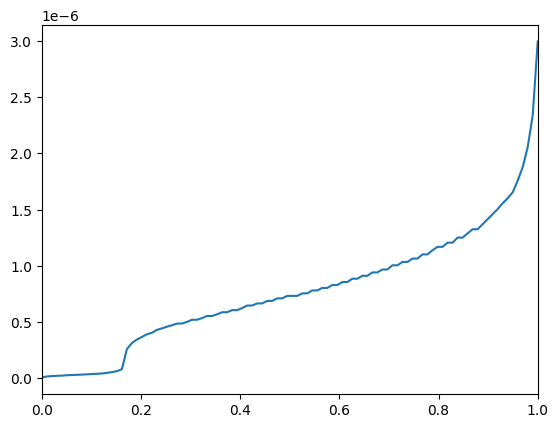

Epoch 1, Loss: 1.3125


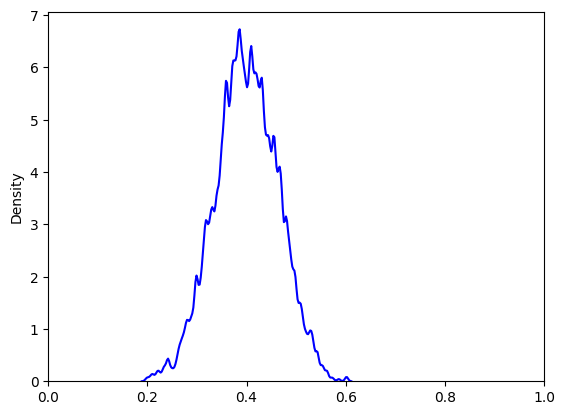

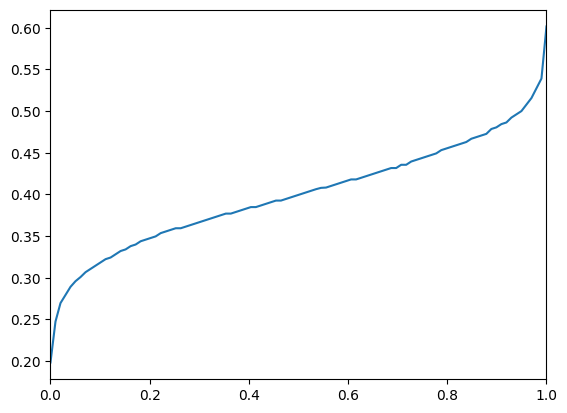

Epoch 2, Loss: 2.15625


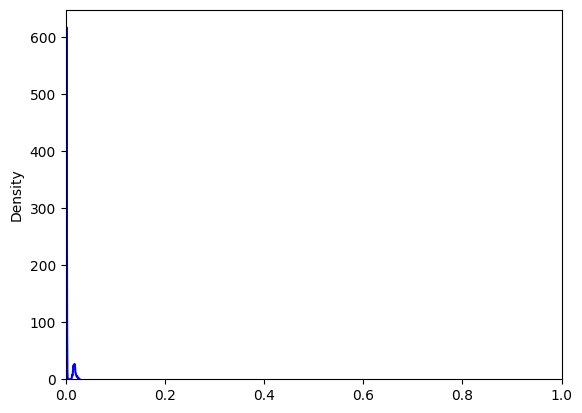

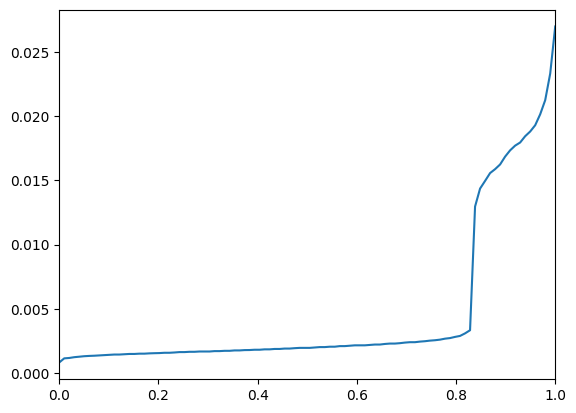

Epoch 3, Loss: 0.65625


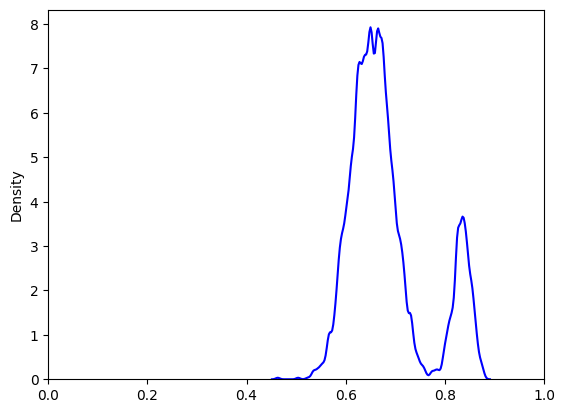

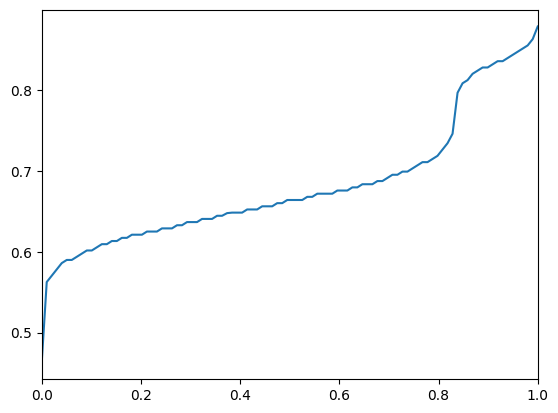

Epoch 4, Loss: 0.62109375


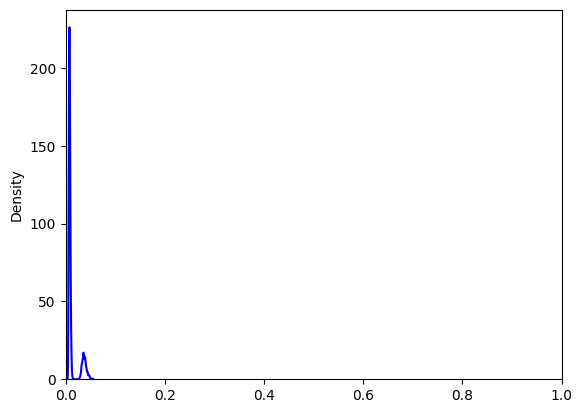

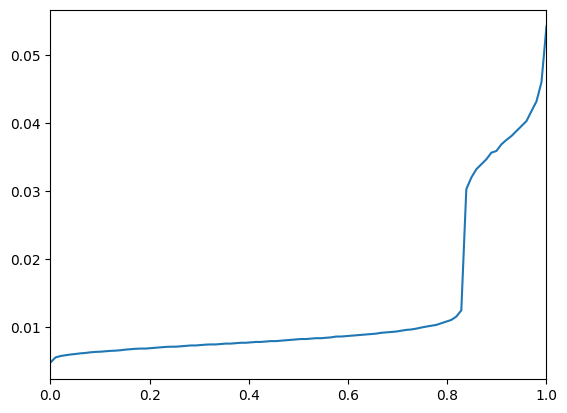

Epoch 5, Loss: 0.88671875


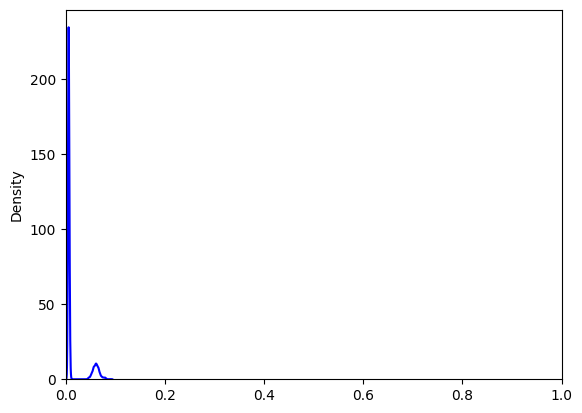

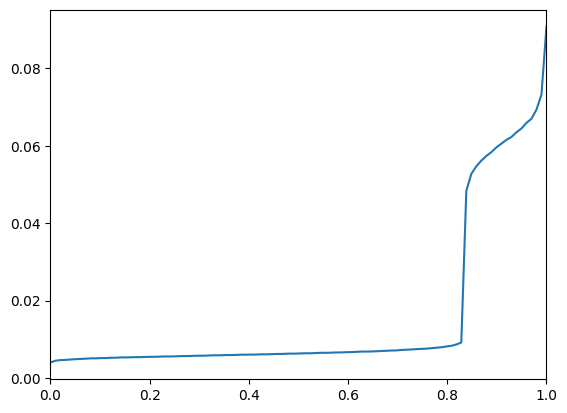

Epoch 6, Loss: 0.423828125


KeyboardInterrupt: 

In [10]:
losses = []
batch_count = 0
model.train()
for training_batch in data_loader:  # Training for 3 epochs
    input_ids, attention_mask, labels = training_batch['input_ids'].to(device), training_batch['attention_mask'].to(device), training_batch['labels'].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(logits, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    batch_predictions = []
    
    for batch in data_loader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_predictions.extend(torch.softmax(logits, dim=-1)[:,1].detach().cpu().double())

    # Flatten the predictions array
    flattened_predictions = np.array(batch_predictions).reshape(-1,)
    
    sns.kdeplot(flattened_predictions, color='blue', fill=False, bw_adjust=0.25, label='Train')
    plt.xlim(0,1)
    plt.show()

    qs = np.linspace(0, 1, 100)
    ys = np.quantile(flattened_predictions, qs)
    plt.plot(qs, ys)
    plt.xlim(0,1)
    plt.show()

    print(f"Epoch {batch_count + 1}, Loss: {loss.item()}")
    batch_count += 1 

In [ ]:
batch_predictions

In [ ]:

plt.plot(losses)